In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [0]:
path_raw_data = "/path/to/data/"
!ls $path_raw_data

'ETF prices.csv'	       'MutualFund prices - L-P.csv'
 ETFs.csv		       'MutualFund prices - Q-Z.csv'
'MutualFund prices - A-E.csv'  'MutualFund prices.csv'
'MutualFund prices - F-K.csv'   MutualFunds.csv


In [0]:
# etf data
etf_df = pd.read_csv(path_raw_data + "ETFs.csv")

# # mutual fund data
# mf_df = pd.read_csv(path_raw_data + "MutualFunds.csv")

# etf prices data
etf_prices_df = pd.read_csv(path_raw_data + "ETF prices.csv")

# # mutual fund prices data
# mf_prices_ae_df = pd.read_csv(path_raw_data + "MutualFund prices - A-E.csv")
# mf_prices_fk_df = pd.read_csv(path_raw_data + "MutualFund prices - F-K.csv")
# mf_prices_lp_df = pd.read_csv(path_raw_data + "MutualFund prices - L-P.csv")
# mf_prices_qz_df = pd.read_csv(path_raw_data + "MutualFund prices - Q-Z.csv")
# mf_prices_df = pd.concat([mf_prices_ae_df, mf_prices_fk_df, mf_prices_lp_df, mf_prices_qz_df], ignore_index=True)
# mf_prices_df.to_csv("/path/to/data/MutualFund prices.csv")
# !ls $path_raw_data


# ***** Exchange Traded Funds *****

In [0]:
print(len(etf_df))
etf_df.head(3)

2310


,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,fund_category,fund_family,exchange_code,exchange_name,exchange_timezone,avg_vol_3month,avg_vol_10day,total_net_assets,day50_moving_average,day200_moving_average,week52_high_low_change,week52_high_low_change_perc,week52_high,week52_high_change,week52_high_change_perc,week52_low,week52_low_change,week52_low_change_perc,investment_strategy,fund_yield,inception_date,annual_holdings_turnover,investment_type,size_type,fund_annual_report_net_expense_ratio,category_annual_report_net_expense_ratio,asset_stocks,asset_bonds,fund_sector_basic_materials,fund_sector_communication_services,fund_sector_consumer_cyclical,fund_sector_consumer_defensive,fund_sector_energy,fund_sector_financial_services,...,category_return_2009,fund_return_2008,category_return_2008,fund_return_2007,category_return_2007,fund_return_2006,category_return_2006,fund_return_2005,category_return_2005,fund_return_2004,category_return_2004,fund_return_2003,category_return_2003,fund_return_2002,category_return_2002,fund_return_2001,category_return_2001,fund_return_2000,category_return_2000,fund_alpha_3years,fund_beta_3years,fund_mean_annual_return_3years,fund_r_squared_3years,fund_stdev_3years,fund_sharpe_ratio_3years,fund_treynor_ratio_3years,fund_alpha_5years,fund_beta_5years,fund_mean_annual_return_5years,fund_r_squared_5years,fund_stdev_5years,fund_sharpe_ratio_5years,fund_treynor_ratio_5years,fund_alpha_10years,fund_beta_10years,fund_mean_annual_return_10years,fund_r_squared_10years,fund_stdev_10years,fund_sharpe_ratio_10years,fund_treynor_ratio_10years
0,AAAU,ETF,US,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,USD,NaN,DWS,PCX,NYSEArca,America/New_York,239238,255410.0,3.844486e+08,17.807,17.818,2.75,0.14146,19.44,-1.7200,-0.08848,16.69,1.03000,0.06171,The investment seeks total return in excess of...,NaN,2018-07-24,NaN,NaN,NaN,0.0018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.18,0.07,1.23,0.54,14.93,0.91,187.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AADR,ETF,US,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,USD,Foreign Large Growth,Virtus,NGM,NasdaqGM,America/New_York,2596,3170.0,8.883616e+07,64.555,65.297,11.82,0.17042,69.36,-7.8645,-0.11339,57.54,3.95550,0.06874,The investment seeks long-term capital appreci...,0.0031,2010-07-20,NaN,Blend,Large,0.0110,0.0066,NaN,NaN,0.2536,0.0736,0.1164,0.0000,0.0455,0.1125,...,0.29080,NaN,-0.42427,NaN,0.31193,NaN,0.21884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.30,1.11,0.85,75.96,22.42,0.40,6.11,0.38,1.11,1.10,70.49,19.30,0.62,9.66,3.32,0.96,0.79,73.64,16.78,0.53,8.15
2,AAXJ,ETF,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,Pacific/Asia ex-Japan Stk,American Century Investments,NGM,NasdaqGM,America/New_York,1036417,1287600.0,5.574672e+09,86.132,90.435,19.99,0.19514,102.44,-19.4300,-0.18967,82.45,0.56001,0.00679,The investment seeks the highest total return ...,0.0110,2008-08-13,0.23,Blend,Large,0.0070,0.0054,NaN,NaN,0.0523,0.1053,0.1683,0.0474,0.0266,0.1824,...,0.73761,NaN,-0.51342,NaN,0.39069,NaN,0.37975,NaN,0.14049,NaN,0.21046,NaN,0.38684,NaN,-0.07992,NaN,0.02745,NaN,-0.16595,1.20,0.90,0.80,74.34,18.48,0.46,7.80,1.89,0.94,0.97,73.28,15.91,0.66,10.37,0.30,0.99,0.55,78.24,16.83,0.36,4.81


In [0]:
print(f"count of unique funds in the data = {etf_df['fund_symbol'].nunique()}")

count of unique funds in the data = 2310


## 1. Data type

In [0]:
data_types = etf_df.dtypes # data types of every column
type_counts = data_types.value_counts() # count
print("Data type counts:")
print(type_counts)

Data type counts:
float64    124
object      17
int64        1
dtype: int64


In [0]:
object_cols = etf_df.select_dtypes(include=['object']).columns # object columns
print(object_cols)

Index(['fund_symbol', 'quote_type', 'region', 'fund_short_name',
       'fund_long_name', 'currency', 'fund_category', 'fund_family',
       'exchange_code', 'exchange_name', 'exchange_timezone',
       'investment_strategy', 'inception_date', 'investment_type', 'size_type',
       'top10_holdings', 'returns_as_of_date'],
      dtype='object')


In [0]:
etf_df['inception_date'] = pd.to_datetime(etf_df['inception_date']) # convert 'inception_date' column to datetime
etf_df['returns_as_of_date'] = pd.to_datetime(etf_df['returns_as_of_date']) # convert 'returns_as_of_date' column to datetime

# rechecking data types now
data_types = etf_df.dtypes 
type_counts = data_types.value_counts() 
print("Data type counts:")
print(type_counts)

Data type counts:
float64           124
object             15
datetime64[ns]      2
int64               1
dtype: int64


In [0]:
# dropping one class called 'Other OTC' in the column 'exchange_name' as we wish to analyze only for major exchanges

print(etf_df['exchange_name'].nunique())
etf_df = etf_df[etf_df['exchange_name']!='Other OTC']
print(etf_df['exchange_name'].nunique()) # rechecking if implemented
print(len(etf_df)) # new length of the dataframe


4
3
2302


## 2. Missing values

In [0]:
missing_values = etf_df.isnull().sum() # missing values in each column
missing_cols = missing_values[missing_values > 0].sort_values() # boolean mask to filter columns with missing values
print(f"{len(missing_cols)} / {etf_df.shape[1]} columns have atleast 1 missing value")
max_missing_cols = missing_values[missing_values == missing_values.max()].index.tolist()
print(f"{len(max_missing_cols)} column(s) namely *** {max_missing_cols} *** are missing maximum values = {missing_values[max_missing_cols[0]]}")
print(f"5 columns with minimum missing values and their count")
print(missing_cols.head(5)) # 5 columns with minimum missing values and their count
print(f"5 columns with maximum missing values and their count")
print(missing_cols.tail(5)) # 5 columns with maximum missing values and their count

129 / 142 columns have atleast 1 missing value
5 column(s) namely *** ['category_return_2020', 'category_return_2019', 'category_return_2018', 'category_return_2017', 'category_return_2016'] *** are missing maximum values = 2302
5 columns with minimum missing values and their count
week52_low                1
week52_high               1
day50_moving_average      1
day200_moving_average     1
week52_high_low_change    1
dtype: int64
5 columns with maximum missing values and their count
category_return_2020    2302
category_return_2019    2302
category_return_2018    2302
category_return_2017    2302
category_return_2016    2302
dtype: int64


Now we analyse missing values in the columns of interest

In [0]:
# columns of interest

categorical_cols = ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family']
performance_cols = ['total_net_assets', 'fund_price_earning_ratio', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_mean_annual_return_10years', 'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']


categorical_missing = etf_df[categorical_cols].isna().sum()
performance_missing = etf_df[performance_cols].isna().sum()

print('Missing values in categorical columns:')
print(categorical_missing)
print('\nMissing values in performance columns:')
print(performance_missing)

Missing values in categorical columns:
exchange_name        0
investment_type    621
size_type          621
fund_category      622
fund_family          0
dtype: int64

Missing values in performance columns:
total_net_assets                     30
fund_price_earning_ratio            806
fund_mean_annual_return_5years     1167
fund_sharpe_ratio_5years           1169
fund_treynor_ratio_5years          1167
fund_mean_annual_return_10years    1697
fund_sharpe_ratio_10years          1698
fund_treynor_ratio_10years         1697
dtype: int64


In [0]:
# etf_df = etf_df.dropna(subset=categorical_cols + performance_cols)
# print(len(etf_df)) # gives 337

If I remove all rows with null values in any of the columns of interest, then I am left with a significantly small dataset with 337 rows --> huge data loss.

Data amputation (filling proxies) is tricky because the fund performances are characteristics of so many factors. Later, if we find correlation in 5 year and 10 year performances, we can proxy one value for another while modeling. This will lead to lesser data loss.

So I instead remove only those rows that have null values together in ALL columns of interest.

Then I also drop rows with null values in categorical columns --> i.e. ['investment_type', 'size_type', 'fund_category']

In [0]:
etf_df = etf_df.dropna(subset=categorical_cols + performance_cols, how='all') # remove only those rows that have null values together in ALL columns of interest.

categorical_cols_to_dropna = ['investment_type', 'size_type', 'fund_category'] # categorical columns to drop null values from
etf_df = etf_df.dropna(subset=categorical_cols_to_dropna)

print(len(etf_df))

1229


## 3. Visualising categorical distributions

In [0]:
categorical_cols = ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family'] # categorical columns handpicked from object columns

print(f"Column : Types (unique values)")
for i, col in enumerate(categorical_cols):
    num_unique = len(etf_df[col].unique()) 
    print(f"{col} : {num_unique}")

Column : Types (unique values)
exchange_name : 3
investment_type : 3
size_type : 3
fund_category : 62
fund_family : 112


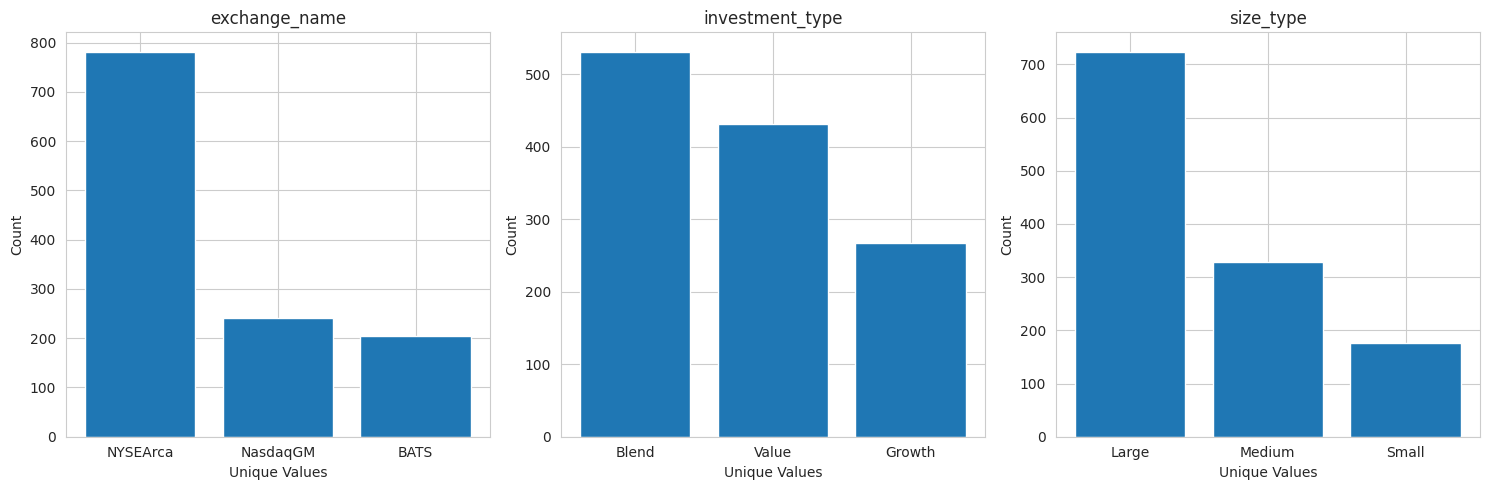

In [0]:
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']  # categorical columns with few unique values
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for i, col in enumerate(categorical_cols_1):
    value_counts = etf_df[col].value_counts().sort_values(ascending=False) # number of occurrences of each unique value
    axs[i].bar(value_counts.index, value_counts.values) # bar plots
    axs[i].set_title(col)
    axs[i].set_xlabel('Unique Values')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

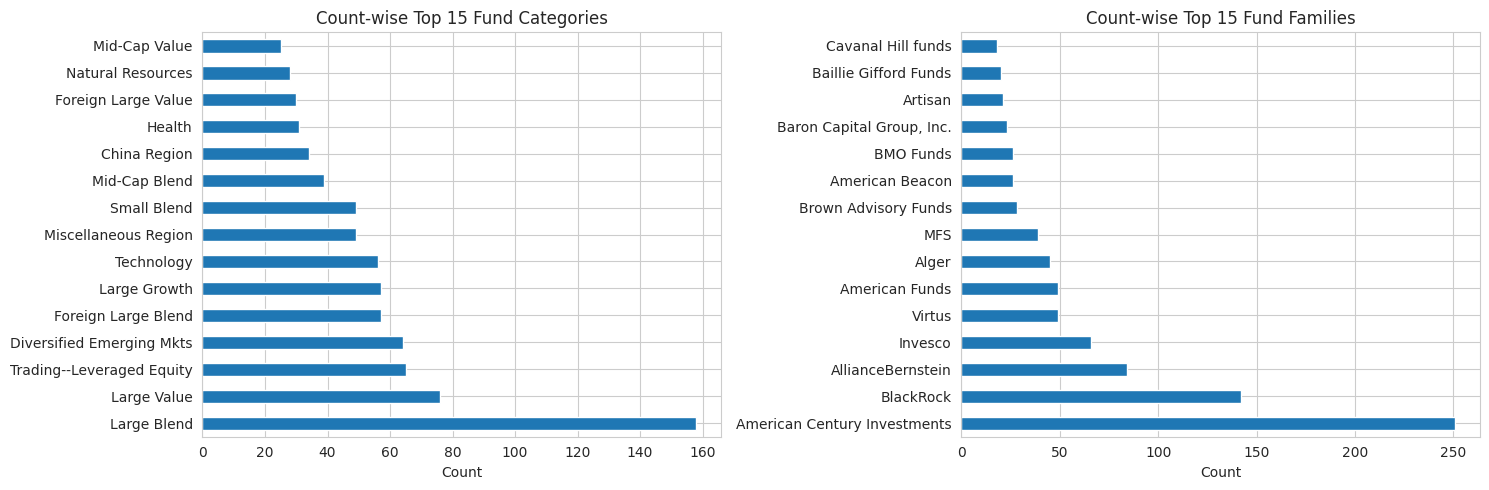

In [0]:
categorical_cols_2 = ['fund_category', 'fund_family']  # categorical columns with many unique values

category_counts = etf_df[categorical_cols_2[0]].value_counts().sort_values(ascending=False)  # number of occurrences of each unique value
family_counts = etf_df[categorical_cols_2[1]].value_counts().sort_values(ascending=False)

top_categories = category_counts[:15] # top 15 categories and families
top_families = family_counts[:15]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
top_categories.plot(kind='barh', ax=axs[0])
axs[0].set_title('Count-wise Top 15 Fund Categories')
axs[0].set_xlabel('Count')
top_families.plot(kind='barh', ax=axs[1])
axs[1].set_title('Count-wise Top 15 Fund Families')
axs[1].set_xlabel('Count')
plt.tight_layout()
plt.show()

## 4. Visualising fund performance over categories

In [0]:
for i in range (0, len(etf_df.columns)):
    print(etf_df.columns[i])

fund_symbol
quote_type
region
fund_short_name
fund_long_name
currency
fund_category
fund_family
exchange_code
exchange_name
exchange_timezone
avg_vol_3month
avg_vol_10day
total_net_assets
day50_moving_average
day200_moving_average
week52_high_low_change
week52_high_low_change_perc
week52_high
week52_high_change
week52_high_change_perc
week52_low
week52_low_change
week52_low_change_perc
investment_strategy
fund_yield
inception_date
annual_holdings_turnover
investment_type
size_type
fund_annual_report_net_expense_ratio
category_annual_report_net_expense_ratio
asset_stocks
asset_bonds
fund_sector_basic_materials
fund_sector_communication_services
fund_sector_consumer_cyclical
fund_sector_consumer_defensive
fund_sector_energy
fund_sector_financial_services
fund_sector_healthcare
fund_sector_industrials
fund_sector_real_estate
fund_sector_technology
fund_sector_utilities
fund_price_book_ratio
fund_price_cashflow_ratio
fund_price_earning_ratio
fund_price_sales_ratio
fund_bond_maturity
fund_b

In [0]:
# We study the following performances for different fund categories

performance_cols = ['total_net_assets', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_price_earning_ratio']

categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

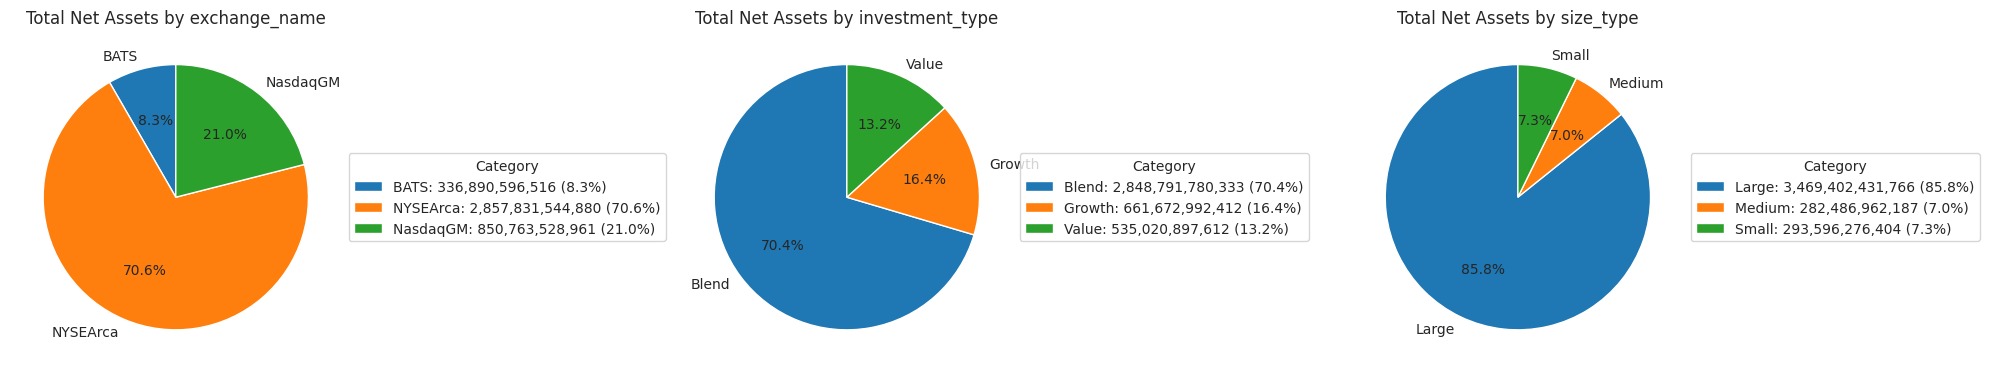

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# pie chart of total net assets
for i, col in enumerate(categorical_cols_1):
    data = etf_df.groupby(col)['total_net_assets'].sum().reset_index() # sum
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(data['total_net_assets'], labels=data[col], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Total Net Assets by {col}')

    abs_vals = [f'{val:,.0f}' for val in data['total_net_assets']]
    legend_labels = [f'{cat}: {abs_val} ({val/sum(data["total_net_assets"])*100:.1f}%)' for cat, abs_val, val in zip(data[col], abs_vals, data['total_net_assets'])]
    ax.legend(wedges, legend_labels, title='Category', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

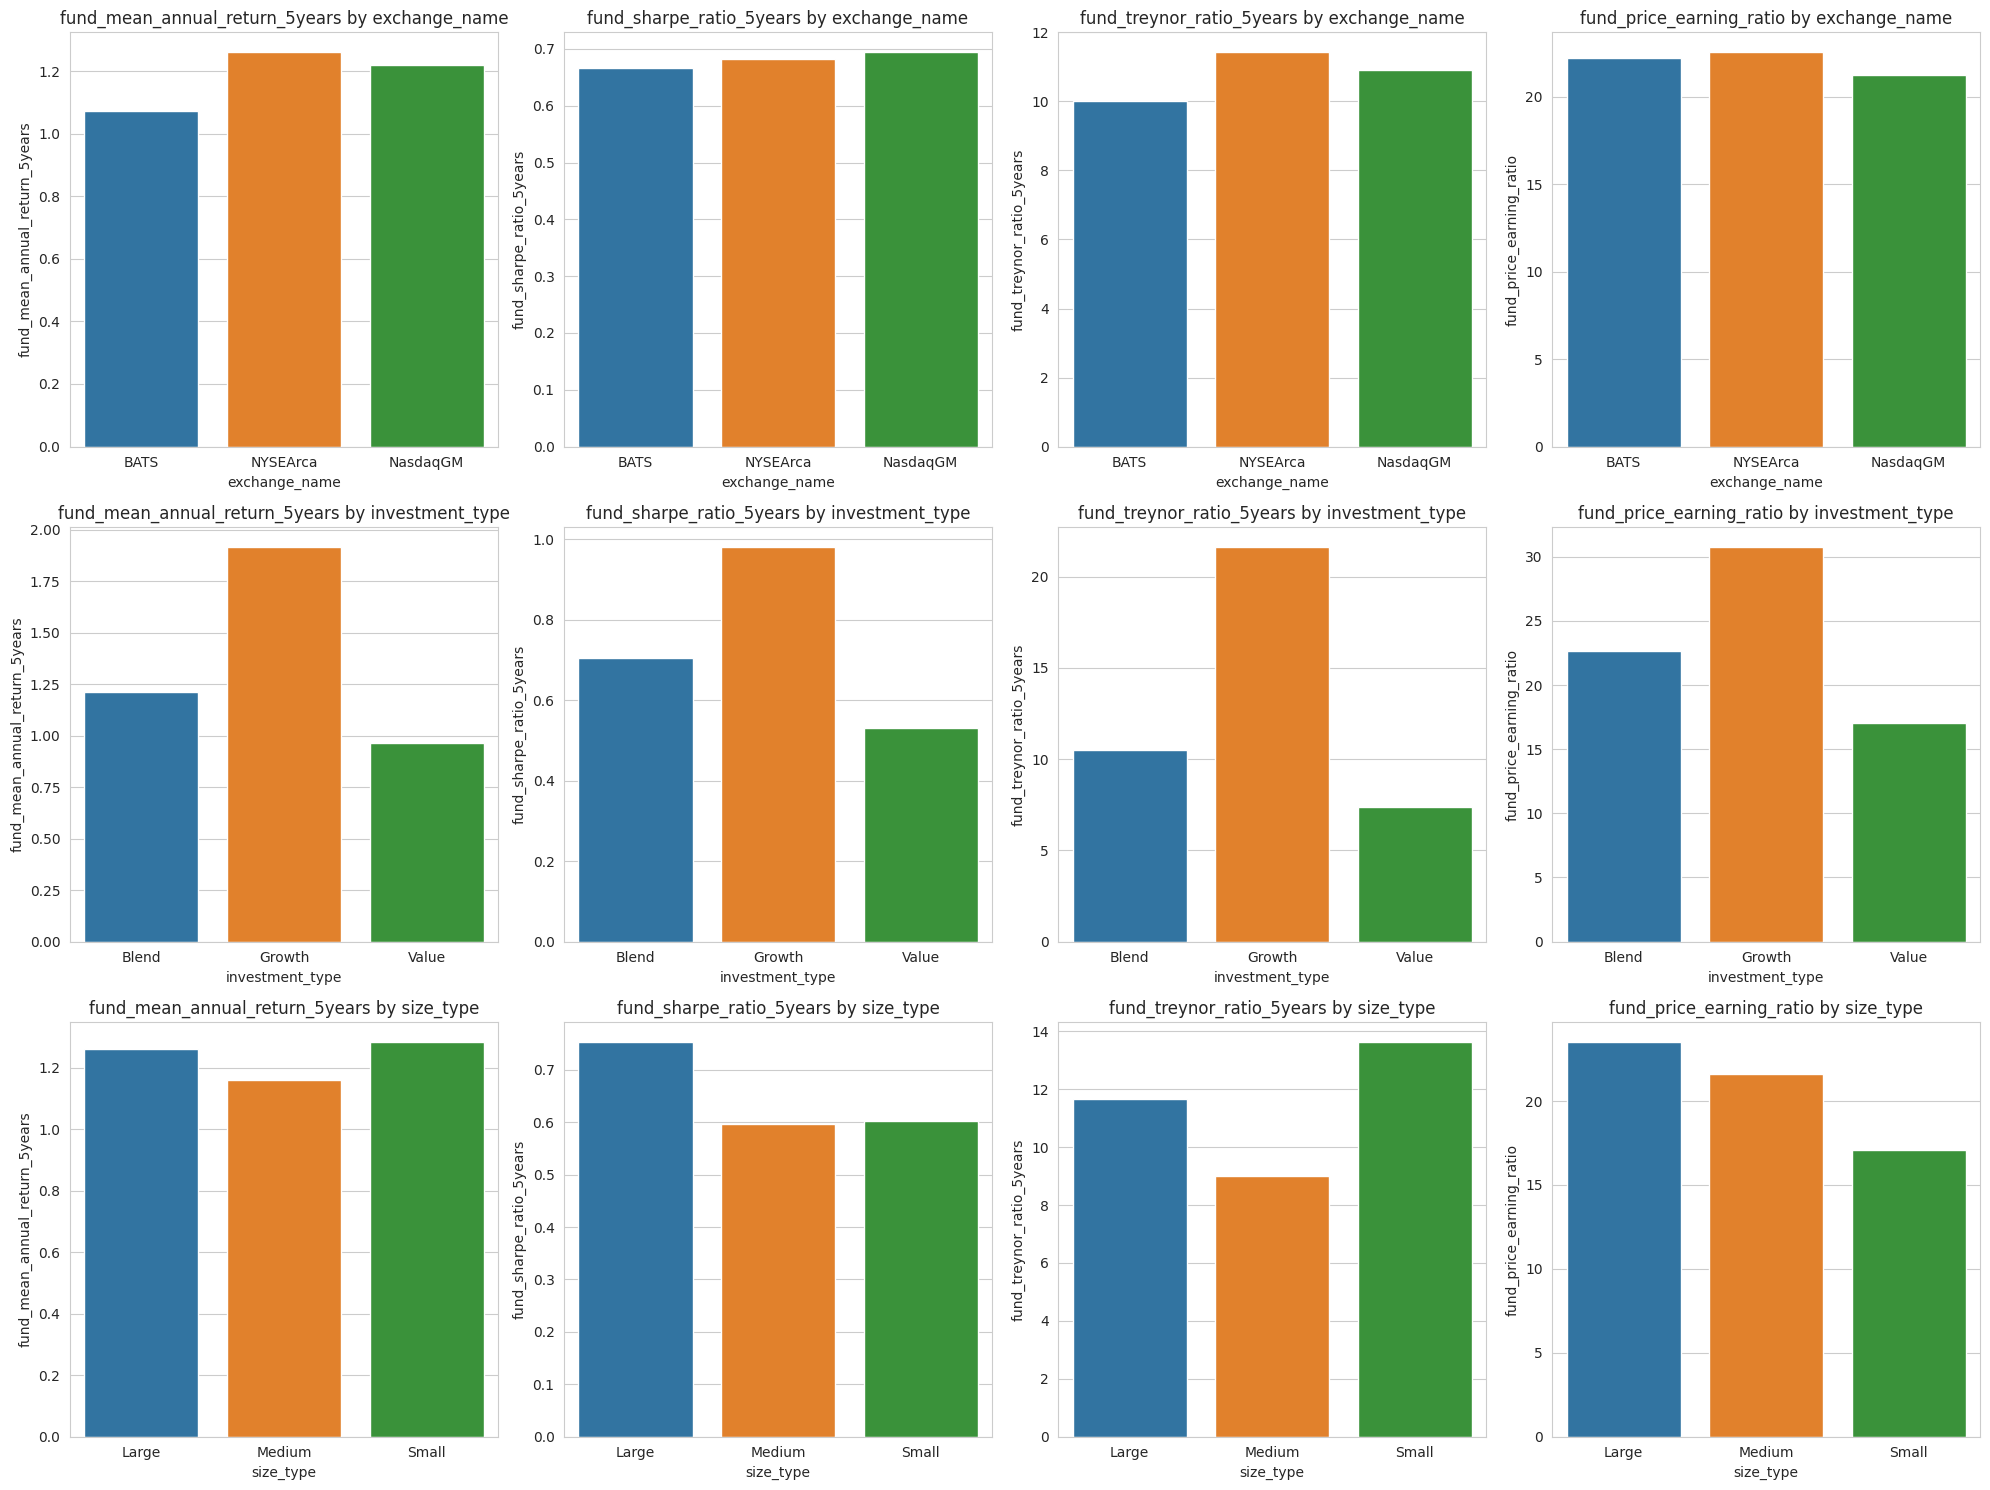

In [0]:
# bar plots now for Financial Performance

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, col in enumerate(performance_cols[1:]):
    for j, cat_col in enumerate(categorical_cols_1):
        data = etf_df.groupby(cat_col)[col].mean().reset_index() # average

        ax = axs[j, i]
        sns.barplot(x=cat_col, y=col, data=data, ax=ax)
        ax.set_title(f'{col} by {cat_col}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(col)

plt.tight_layout()
plt.show()

## 5. Correlations (Overall + Conditioned on Categories)

### 5.1. Overall

<AxesSubplot:>

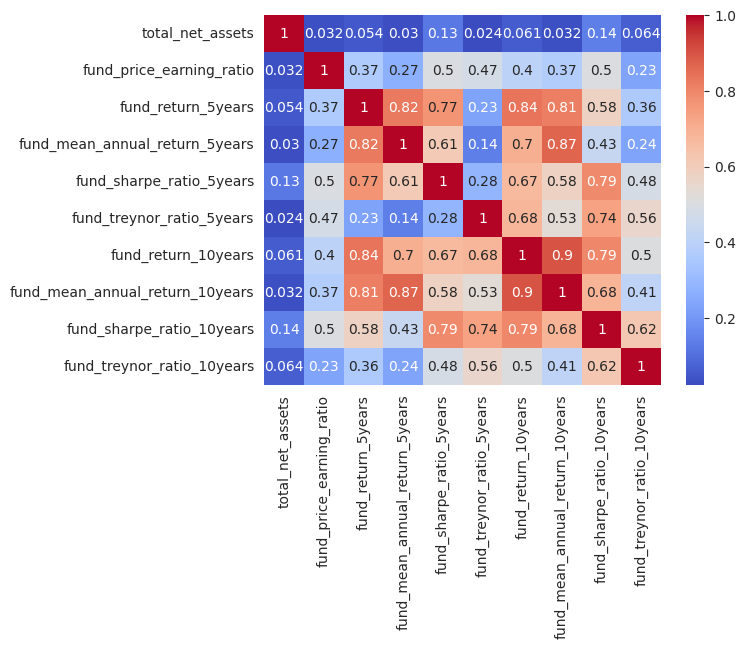

In [0]:
performance_cols = ['total_net_assets', 'fund_price_earning_ratio', 'fund_return_5years', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_return_10years', 'fund_mean_annual_return_10years', 'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

normalized_df = etf_df.copy() 
scaler = StandardScaler()
normalized_df[performance_cols] = scaler.fit_transform(etf_df[performance_cols]) # normalized data

corr_matrix = normalized_df[performance_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### 5.2. Conditioned on Categories

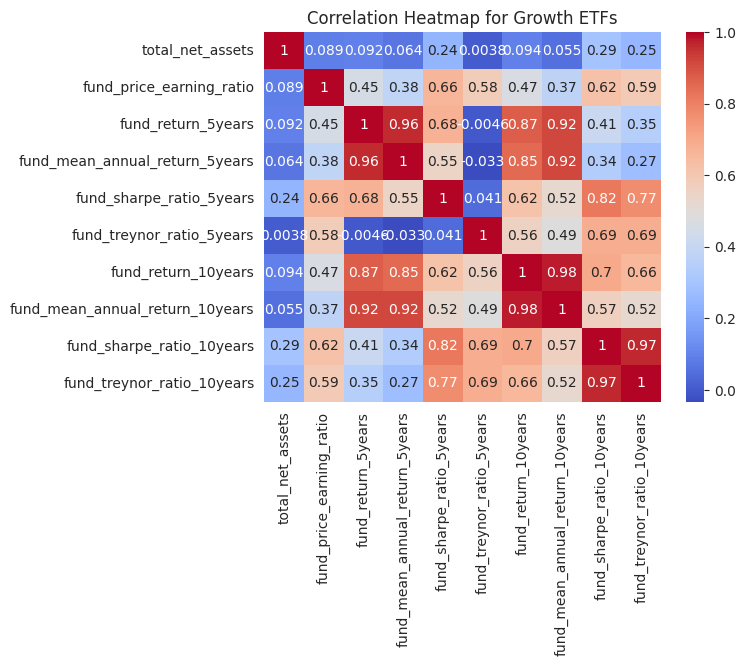

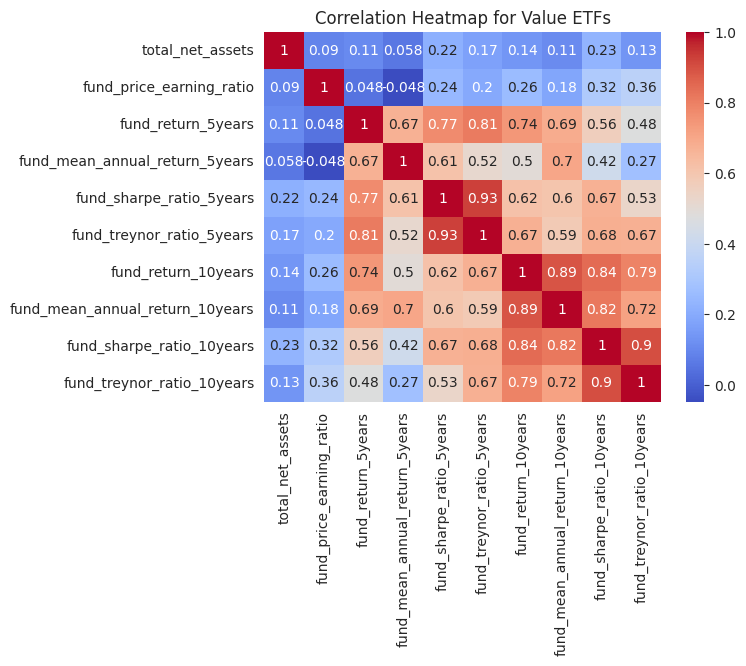

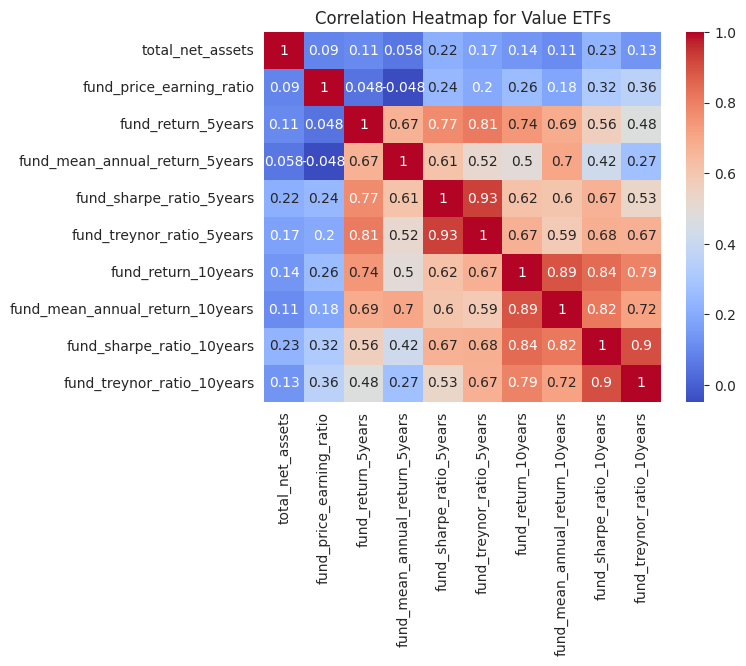

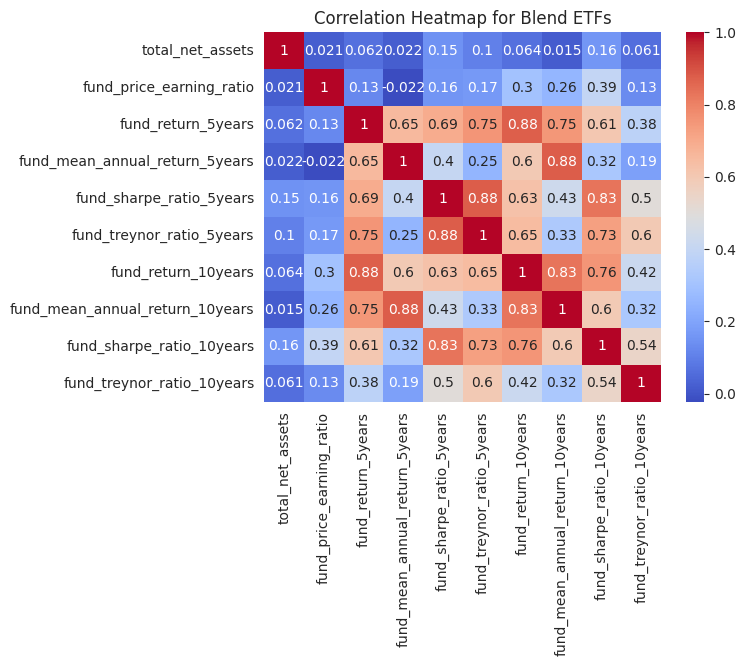

In [0]:
investment_types_ = ['Growth', 'Value', 'Blend'] 
for type_ in investment_types_:
    corr_matrix = normalized_df[normalized_df['investment_type']==type_][performance_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap for {type_} ETFs')
    plt.show()

# size_types_ = ['Small', 'Medium', 'Large'] 
# for type_ in size_types_:
#     corr_matrix = normalized_df[normalized_df['size_type']==type_][performance_cols].corr()
#     sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#     plt.title(f'Correlation Heatmap for {type_} ETFs')
#     plt.show()

## 6. ETF prices over time

In [0]:
print(len(etf_prices_df))
etf_prices_df.head(5)

3866030


,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100


In [0]:
print(etf_prices_df.dtypes) # data types of every column

etf_prices_df['price_date'] = pd.to_datetime(etf_prices_df['price_date']) # convert 'price_date' column to datetime

print("*****")
print(etf_prices_df['price_date'].dtypes) # new data types of price_date

print("*****")
# range of time for which data is available
print(f"{etf_prices_df['price_date'].min()} to {etf_prices_df['price_date'].max()}")

fund_symbol     object
price_date      object
open           float64
high           float64
low            float64
close          float64
adj_close      float64
volume           int64
dtype: object
*****
datetime64[ns]
*****
1993-01-29 00:00:00 to 2021-11-30 00:00:00


price_date
1993       234
1994       252
1995       252
1996       857
1997      1012
1998      1249
1999      1467
2000      3826
2001      7260
2002      8866
2003      9947
2004     12016
2005     15302
2006     23638
2007     57617
2008     82227
2009     99207
2010    125364
2011    150419
2012    173942
2013    194737
2014    220997
2015    251382
2016    286312
2017    322957
2018    377515
2019    428259
2020    490621
2021    518296
dtype: int64


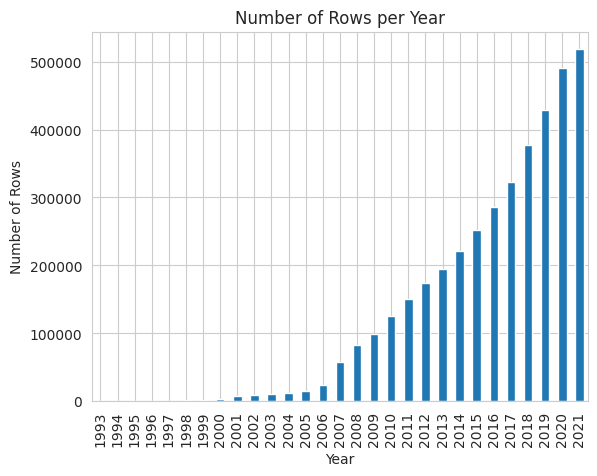

In [0]:
# visualising YoY entries in the price dataframe

year_counts = etf_prices_df.groupby(etf_prices_df['price_date'].dt.year).size()
print(year_counts)

year_counts.plot(kind='bar') # bar plot
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Year')
plt.show()

In [0]:
# trimming dataset before 2001 since I wish to analyse from this year
etf_prices_df = etf_prices_df[etf_prices_df['price_date'] > '2000-12-31']
print(len(etf_prices_df))
etf_prices_df.head(3)

3856881


,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400


In [0]:
# adding categorical_cols in the etf_prices dataframe 
categorical_cols= ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family'] # categorical columns handpicked from object columns
etf_prices_df = etf_prices_df.merge(etf_df[categorical_cols + ['fund_symbol']], on='fund_symbol', how='left')
etf_prices_df.head(5)

,fund_symbol,price_date,open,high,low,close,adj_close,volume,exchange_name,investment_type,size_type,fund_category,fund_family
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300,NaN,NaN,NaN,NaN,NaN
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500,NaN,NaN,NaN,NaN,NaN
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400,NaN,NaN,NaN,NaN,NaN
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100,NaN,NaN,NaN,NaN,NaN
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100,NaN,NaN,NaN,NaN,NaN


###  6.1. year on year split of ETF funds on categorical columns i.e. Count of ETFs v/s categorical columns

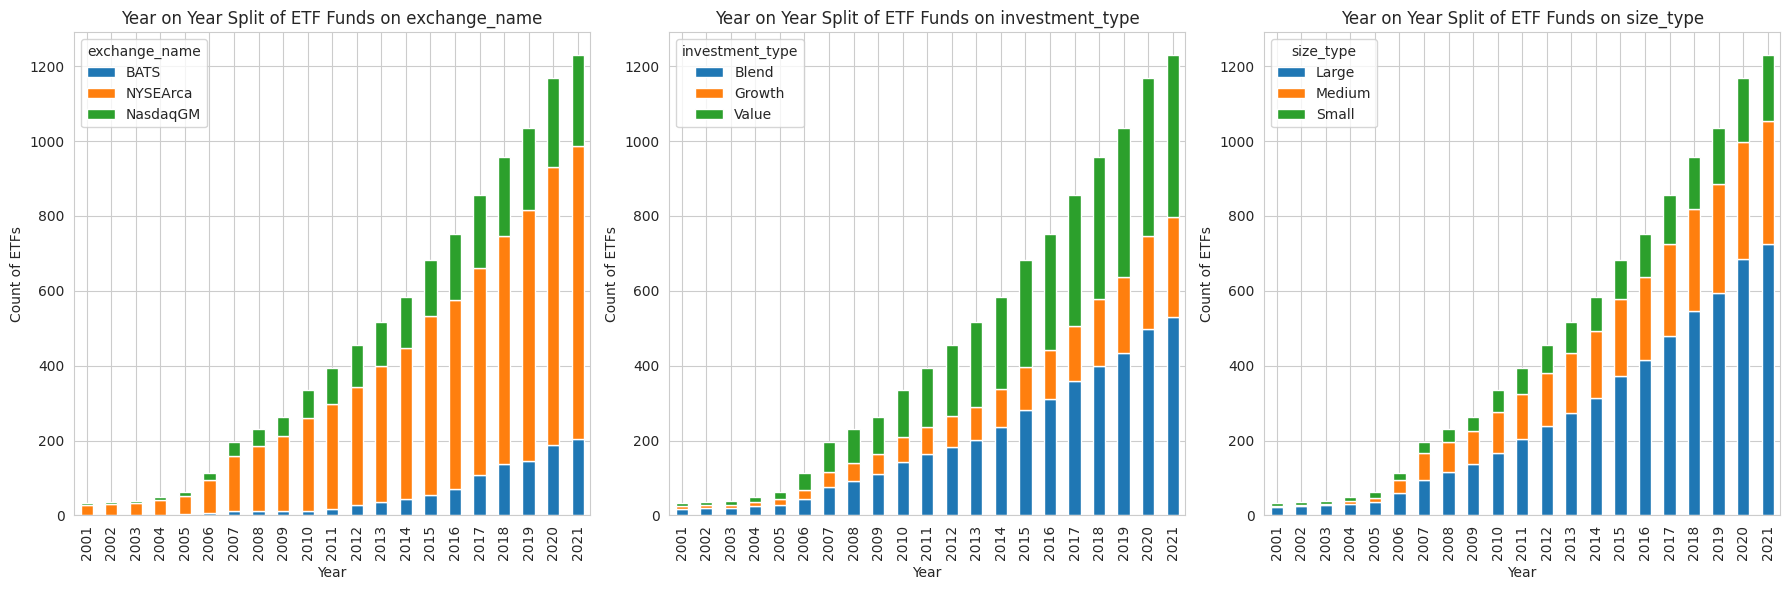

In [0]:
etf_prices_df.set_index('price_date', inplace=True)

categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(categorical_cols_1):
    etf_category_count_df = etf_prices_df.groupby([etf_prices_df.index.year, col])['fund_symbol'].nunique().reset_index(name='count')
    etf_category_count_pivot = etf_category_count_df.pivot(index='price_date', columns=col, values='count').fillna(0)
    
    sns.set_style('whitegrid')
    etf_category_count_pivot.plot(kind='bar', stacked=True, ax=axs[i]) # stacked bar_plot
    #etf_category_count_pivot.plot(kind='line', ax=axs[i])
    axs[i].set_title(f'Year on Year Split of ETF Funds on {col}')
    axs[i].set_xlabel('Year')
    axs[i].set_xticklabels(etf_category_count_pivot.index, rotation=90)
    axs[i].set_ylabel('Count of ETFs')

plt.tight_layout()
plt.show()

###  6.2. year on year split of 'year on year trading volume of ETF funds' on categorical columns i.e. YoY total trading volume of ETFs v/s categorical columns

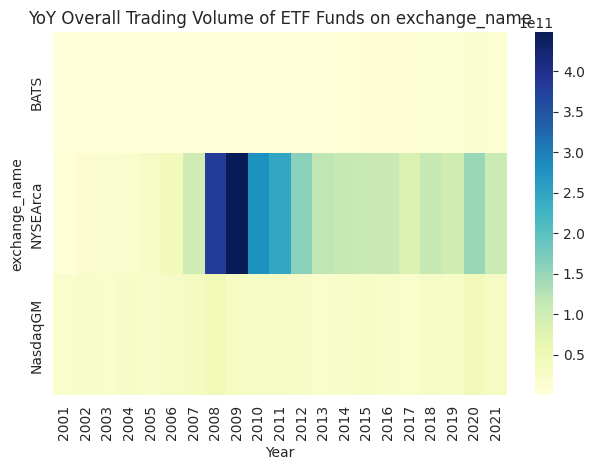

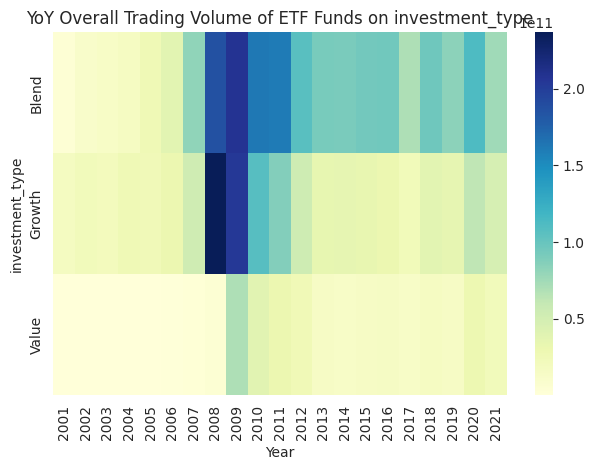

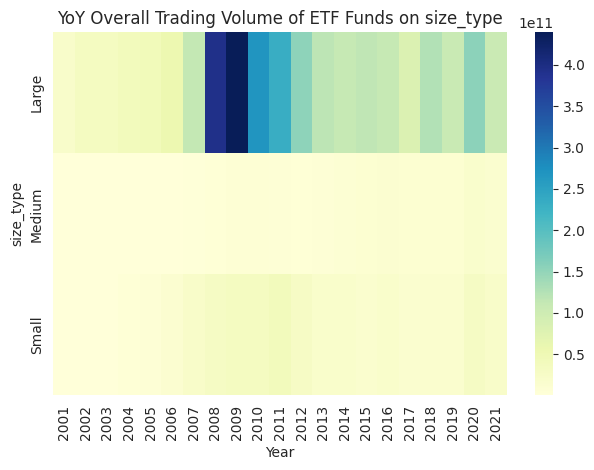

In [0]:
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

for col in categorical_cols_1:
    etf_volume_df = etf_prices_df.groupby([etf_prices_df.index.year, col])['volume'].sum().reset_index(name='total_volume')

    etf_volume_pivot = etf_volume_df.pivot(index=col, columns='price_date', values='total_volume')

    sns.set_style('whitegrid')
    sns.heatmap(etf_volume_pivot, cmap='YlGnBu')
    plt.title(f'YoY Overall Trading Volume of ETF Funds on {col}')
    plt.xlabel('Year')
    plt.xticks(rotation=90)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Trading volume is the total number of shares or units of an ETF that are traded on a particular day. It can provide insights into the liquidity and demand for the ETF. 
    # Higher trading volume generally indicates higher liquidity and demand, which can make it easier to buy and sell the ETF at a fair price.

*****